##Easy second order derivatives with JAX
Playing with JAX's higher order derivatives.
Illustrating it with an implementation of Newton's method, which beats Gradient Descent (no bouncing during descent).

In [18]:
# @title 1. Setup and Rosenbrock definition
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def rosenbrock(x):
    # Standard parameters: a=1, b=100
    # f(x, y) = (1 - x)^2 + 100 * (y - x^2)^2
    return (1.0 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2

# Starting point for all experiments
x_start = jnp.array([-1.5, 2.0])

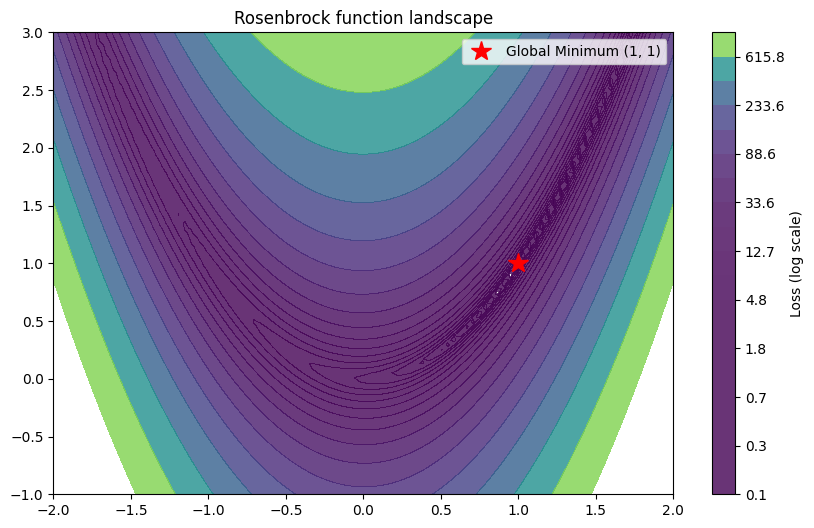

In [19]:
# @title 2. Visualizing the "Banana" valley
# Create a grid of points
x_range = jnp.linspace(-2, 2, 100)
y_range = jnp.linspace(-1, 3, 100)
X, Y = jnp.meshgrid(x_range, y_range)

# Vectorizing the rosenbrock call for the grid
Z = jax.vmap(jax.vmap(lambda x, y: rosenbrock(jnp.array([x, y]))))(X, Y)

plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=jnp.logspace(-1, 3, 20), cmap='viridis', alpha=0.8)
plt.colorbar(label='Loss (log scale)')
plt.plot(1, 1, 'r*', markersize=15, label='Global Minimum (1, 1)')
plt.title("Rosenbrock function landscape")
plt.legend()
plt.show()


In [20]:
# @title 3. Gradient Descent baseline
@jax.jit
def gd_step(x, lr=0.001):
    # jax.grad gives us the first-order derivative
    g = jax.grad(rosenbrock)(x)
    return x - lr * g

# Run GD for 5000 steps to see how far it gets
x_gd = x_start
gd_history = [x_gd]

for _ in range(5000):
    x_gd = gd_step(x_gd)
    gd_history.append(x_gd)

x_gd_final = x_gd
print(f"GD Final Position: {x_gd_final}")
print(f"GD Final Loss: {rosenbrock(x_gd_final):.6f}")

GD Final Position: [0.9193595  0.84488326]
GD Final Loss: 0.006514


In [21]:
# @title 4. Second-order primitives in JAX
# First-order gradient for direction.
grad_fn = jax.grad(rosenbrock)

# Second-order Hessian for curvature.
# JAX computes the full matrix of second-order partial derivatives.
hessian_fn = jax.hessian(rosenbrock)

# Check the shapes to verify.
test_x = jnp.array([0.0, 0.0])
print(f"Gradient shape: {grad_fn(test_x).shape}")
print(f"Hessian shape:  {hessian_fn(test_x).shape}")

Gradient shape: (2,)
Hessian shape:  (2, 2)


In [22]:
# @title 5. Newton step and linear system solving
@jax.jit
def newton_step(x):
    """
    Compute one iteration using the local quadratic approximation.
    """
    g = grad_fn(x)
    H = hessian_fn(x)

    # Solve the system H * step = g.
    # This is more stable than computing the inverse of H.
    step = jnp.linalg.solve(H, g)
    return x - step

In [23]:
# @title 6. Execution and convergence comparison
# Initialize starting point for Newton.
x_newton = x_start
newton_history = [x_newton]

print(f"Starting Newton's method at {x_newton}\n")

for i in range(10):
    loss = rosenbrock(x_newton)
    print(f"Iter {i} | Loss: {loss:12.6f} | x: {x_newton}")

    if loss < 1e-10:
        print("Convergence reached.")
        break

    x_newton = newton_step(x_newton)
    newton_history.append(x_newton)

x_newton_final = x_newton

Starting Newton's method at [-1.5  2. ]

Iter 0 | Loss:    12.500000 | x: [-1.5  2. ]
Iter 1 | Loss:     6.007883 | x: [-1.4509804  2.1029413]
Iter 2 | Loss:   751.436584 | x: [ 0.2043382 -2.6983254]
Iter 3 | Loss:     0.630774 | x: [0.20578744 0.04234624]
Iter 4 | Loss:    39.716431 | x: [0.99964494 0.36908025]
Iter 5 | Loss:     0.000000 | x: [0.9996478 0.9992957]
Iter 6 | Loss:     0.000000 | x: [1.        0.9999999]
Convergence reached.


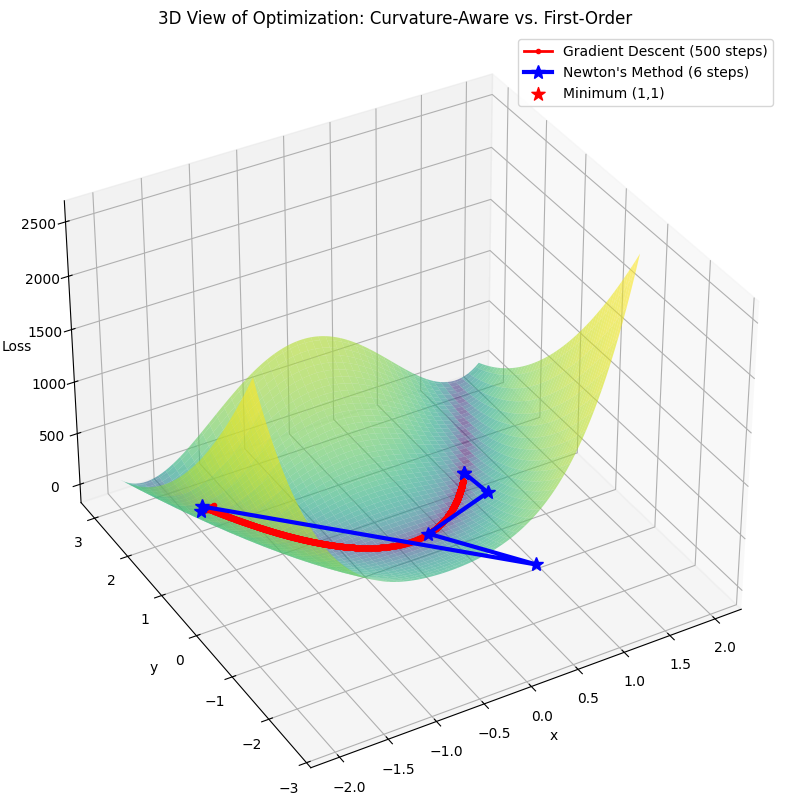

Final GD Loss:     0.0065143555
Final Newton Loss: 0.0000000000


In [31]:
# @title 7. 3D Visualization of the optimization path
from mpl_toolkits.mplot3d import Axes3D

# Generate a high-resolution grid for the 3D surface
x_3d = jnp.linspace(-2.0, 2.0, 100)
y_3d = jnp.linspace(-1.0, 3.0, 100)
X_3d, Y_3d = jnp.meshgrid(x_3d, y_3d)
Z_3d = jax.vmap(jax.vmap(lambda x, y: rosenbrock(jnp.array([x, y]))))(X_3d, Y_3d)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface. Using a log scale for the color map to emphasize the valley floor.
from matplotlib.colors import LogNorm
surface = ax.plot_surface(X_3d, Y_3d, Z_3d, cmap='viridis', norm=LogNorm(),
                          antialiased=True, alpha=0.6)

# Plot the paths. We add a small 'z' offset so the lines don't clip through the floor.
z_offset = 5.0
gd_z = jax.vmap(rosenbrock)(gd_pts) + z_offset
nt_z = jax.vmap(rosenbrock)(nt_pts) + z_offset

# Plot GD path in red
ax.plot(gd_pts[:, 0], gd_pts[:, 1], gd_z, 'r.-', linewidth=2, label='Gradient Descent (500 steps)', zorder=10)

# Plot Newton path in white
ax.plot(nt_pts[:, 0], nt_pts[:, 1], nt_z, 'b*-', markersize=10, linewidth=3, label="Newton's Method (6 steps)", zorder=11)

# Mark the minimum
ax.scatter(1, 1, rosenbrock(jnp.array([1.0, 1.0])) + z_offset, color='red', s=100, marker='*', label='Minimum (1,1)')

ax.set_title("3D View of Optimization: Curvature-Aware vs. First-Order")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Loss")
ax.view_init(elev=35, azim=-120) # Adjust these to get the best 'look' at the valley
plt.legend()
plt.show()

print(f"Final GD Loss:     {rosenbrock(x_gd_final):.10f}")
print(f"Final Newton Loss: {rosenbrock(x_newton_final):.10f}")